Librerias

In [30]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import numpy as np

Hallazgos:

- En la columna "hour" hay la misma cantidad de filas para cada hora, es como si estuviera balanceada en lo que refiere a la hora
- En la columna "weekday" hay una cantidad de filas muy similar para cada dia, esta casi balanceado
- En la columna "month" hay una cantidad de filas muy similar para cada mes, esta casi balanceado
- Los viernes tienen un uso mayor a los demás días de semana entre las 10am y las 4pm, y al mismo tiempo cae la demanda hacia las 5pm, por debajo de los demás días en semana
- Sábados y domingos son los días de menor afluencia
- Sábados y domingos tienen mayor demanda a los días de semana entre 10am y las 4pm
- Entre mayo y octubre se presenta el mayor uso de las bicicletas con apróx 325.000 bicicletas por mes

- En realidad las filas no estaban balanceadas para cada valor de columna, dado que la cantidad de usuarios por fila es la que guia la informacion

Df con Query SQL

In [3]:
import sys
sys.path.append('../src')

from database import read_data_sql

query = """
SELECT *
FROM bike_sharing
ORDER BY date_time
"""
df = read_data_sql(query)

df.head(2)

,date_time,holiday,workingday,weather,temp,atemp,hum,windspeed,users,month,hour,weekday
0,2011-01-01 00:00:00,0.0,0.0,clear,9.84,14.395,81.0,0.0,16.0,1,0,5
1,2011-01-01 01:00:00,0.0,0.0,clear,9.02,13.635,80.0,0.0,40.0,1,1,5


In [4]:
#Se evidencia que no hay valores nulos y los tipos de datos son correctos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_time   17544 non-null  object 
 1   holiday     17544 non-null  float64
 2   workingday  17544 non-null  float64
 3   weather     17544 non-null  object 
 4   temp        17544 non-null  float64
 5   atemp       17544 non-null  float64
 6   hum         17544 non-null  float64
 7   windspeed   17544 non-null  float64
 8   users       17544 non-null  float64
 9   month       17544 non-null  int64  
 10  hour        17544 non-null  int64  
 11  weekday     17544 non-null  int64  
dtypes: float64(7), int64(3), object(2)
memory usage: 1.6+ MB


Cambio de indice por nombre de dia en columna "weekday"

In [5]:
weekday_map = {
    6: "Sunday",
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday"
}

df["weekday"] = df["weekday"].map(weekday_map)

#Visualizacion de la cantidad de usuarios por dia de la semana
df["weekday"].value_counts().sort_index(ascending=True)

weekday
Friday       2496
Monday       2520
Saturday     2520
Sunday       2520
Thursday     2496
Tuesday      2496
Wednesday    2496
Name: count, dtype: int64

Grafico Uso Bicicletas por Hora

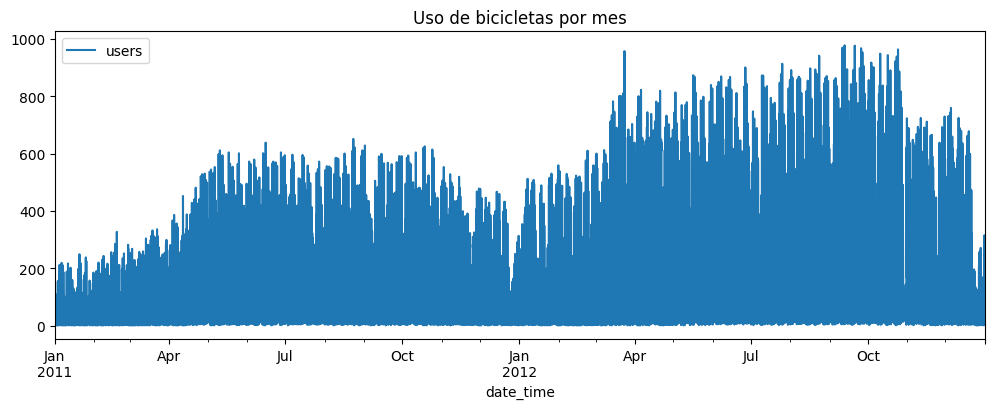

In [6]:
# 1. Parseo de fechas
df["date_time"] = pd.to_datetime(df["date_time"])
df = df.set_index("date_time").sort_index()

df[["users"]].plot(figsize=(12, 4))
plt.title("Uso de bicicletas por mes") #En realidad están los datos de cada hora pero gráficamente se etiqueta mensual
plt.show()

Grafico Resampleo de Datos Diario (sumar todas las horas para agruparlas en un solo dia)

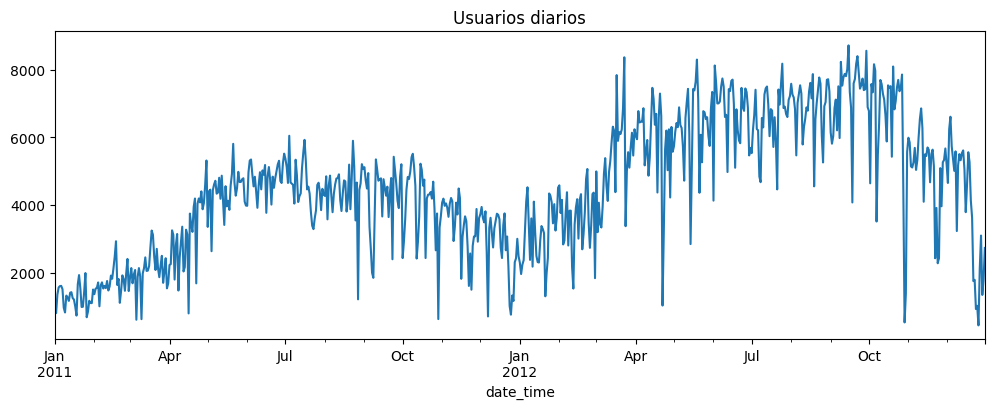

In [7]:
df_daily = df["users"].resample("D").sum()
df_daily.plot(figsize=(12,4))
plt.title("Usuarios diarios")
plt.show()

Graficos de barras ("unique") para variables discretas

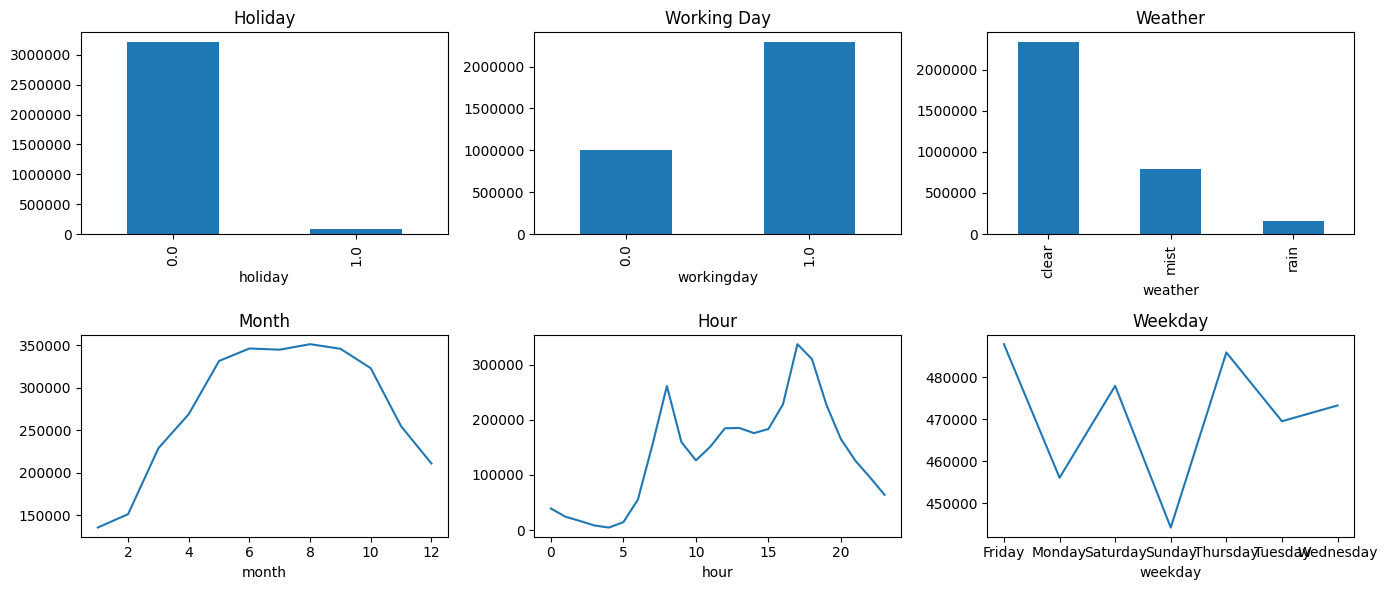

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(14, 6))
axes = axes.flatten()

plots = [
    lambda ax: df.groupby("holiday")["users"].sum().plot(kind="bar", ax=ax, title="Holiday"),
    lambda ax: df.groupby("workingday")["users"].sum().plot(kind="bar", ax=ax, title="Working Day"),
    lambda ax: df.groupby("weather")["users"].sum().plot(kind="bar", ax=ax, title="Weather"),
    lambda ax: df.groupby("month")["users"].sum().plot(kind="line", ax=ax, title="Month"),
    lambda ax: df.groupby("hour")["users"].sum().plot(kind="line", ax=ax, title="Hour"),
    lambda ax: df.groupby("weekday")["users"].sum().plot(kind="line", ax=ax, title="Weekday"),
]

for ax, plot_fn in zip(axes, plots):
    plot_fn(ax)
    ax.ticklabel_format(style="plain", axis="y")  # ← LÍNEA CLAVE

plt.tight_layout()
plt.show()

Graficos de frecuencia ("histograma") para variables continuas

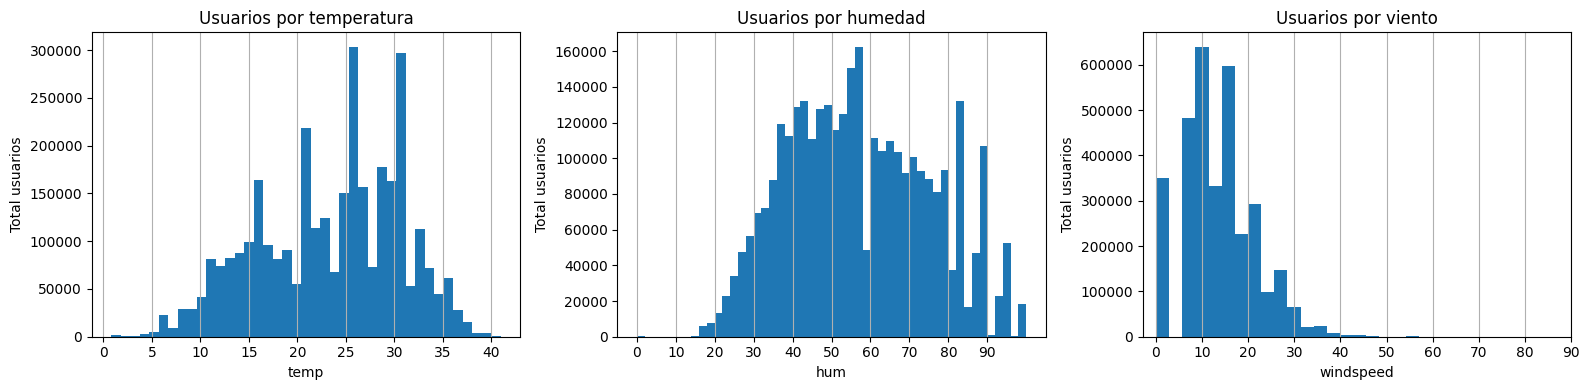

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes = axes.flatten()

axes[0].hist(df["temp"], bins=41, weights=df["users"])
axes[0].set_title("Usuarios por temperatura")
axes[0].set_xlabel("temp")
axes[0].set_xticks(range(0, 45, 5))
axes[0].grid(axis="x")
axes[0].set_ylabel("Total usuarios")

axes[1].hist(df["hum"], bins=50, weights=df["users"])
axes[1].set_title("Usuarios por humedad")
axes[1].set_xlabel("hum")
axes[1].set_xticks(range(0, 100, 10))
axes[1].grid(axis="x")
axes[1].set_ylabel("Total usuarios")

axes[2].hist(df["windspeed"], bins=20, weights=df["users"])
axes[2].set_title("Usuarios por viento")
axes[2].set_xlabel("windspeed")
axes[2].set_xticks(range(0, 100, 10))
axes[2].grid(axis="x")
axes[2].set_ylabel("Total usuarios")


plt.tight_layout()
plt.show()

In [10]:
#Aca se conoce el total de usuarios por cada valor de temperatura (sumado no contado)
df.groupby("temp", as_index = False)["users"].sum().sort_values(by="temp").head(2)

,temp,users
0,0.82,720.0
1,1.64,571.0


In [11]:
#Aca se conocen los limites de los bins en el grafico de histograma de temperatura

counts, bin_edges = np.histogram(
    df["temp"], bins=41, weights=df["users"]
)

#Ahora los llevo a un dataframe
bins_df = pd.DataFrame({
    "bin_min": bin_edges[:-1],
    "bin_max": bin_edges[1:],
    "total_users": counts
})

bins_df.head(2)

,bin_min,bin_max,total_users
0,0.82,1.80,1291.0
1,1.80,2.78,674.0


Total de usuarios por dia y hora

weekday  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday
hour                                                                   
0        5453.0  3571.0    9902.0  9791.0    4071.0   2818.0     3594.0 



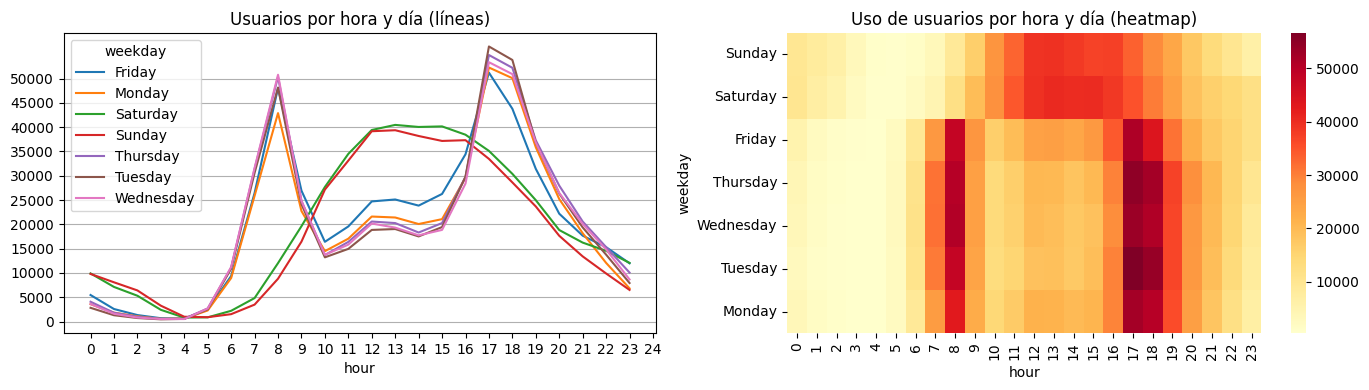

In [12]:
print(pd.pivot_table(df, values="users", index="hour", columns="weekday", aggfunc="sum").head(1),"\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# --- Gráfico 1: líneas ---
pivot_lines = pd.pivot_table(
    df, values="users", index="hour", columns="weekday", aggfunc="sum"
)

pivot_lines.plot(ax=axes[0])
axes[0].set_xticks(range(0, 25, 1))
axes[0].set_yticks(range(0, 55000, 5000))
axes[0].grid(axis="y")
axes[0].set_title("Usuarios por hora y día (líneas)")

# --- Gráfico 2: heatmap ---
pivot_heatmap = pd.pivot_table(
    df, values="users", index="weekday", columns="hour", aggfunc="sum"
)

ordered_days = [
    "Sunday", "Saturday", "Friday",
    "Thursday", "Wednesday", "Tuesday", "Monday"
]

pivot_heatmap = pivot_heatmap.reindex(ordered_days)

sns.heatmap(pivot_heatmap, cmap="YlOrRd", ax=axes[1])
axes[1].set_title("Uso de usuarios por hora y día (heatmap)")

plt.tight_layout()
plt.show()


Matriz de correlacion ponderada para tener en cuenta la cantidad de usuarios por linea (observacion)

In [28]:
def weighted_corr_matrix(df, cols, w):
    def wc(x, y):
        xm = np.average(x, weights=w)
        ym = np.average(y, weights=w)
        cov = np.average((x - xm) * (y - ym), weights=w)
        return cov / (
            np.sqrt(np.average((x - xm)**2, weights=w)) *
            np.sqrt(np.average((y - ym)**2, weights=w))
        )

    return pd.DataFrame(
        [[wc(df[c1], df[c2]) for c2 in cols] for c1 in cols],
        index=cols, columns=cols
    )

cols = ["temp", "hum", "windspeed", "users"]
corr_w = weighted_corr_matrix(df, cols, df["users"])
corr_w

,temp,hum,windspeed,users
temp,1.000000,-0.161654,0.006047,0.331727
hum,-0.161654,1.000000,-0.268428,-0.220088
windspeed,0.006047,-0.268428,1.000000,0.045211
users,0.331727,-0.220088,0.045211,1.000000


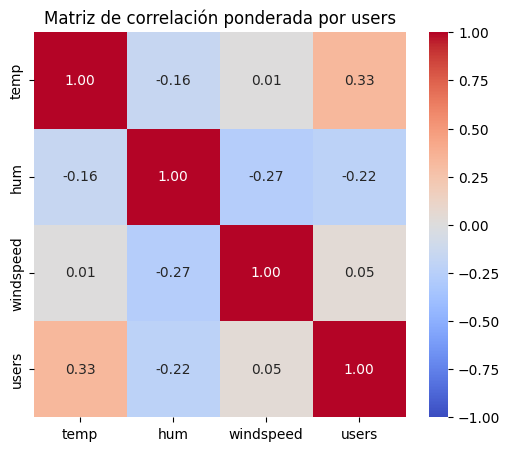

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(corr_w, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matriz de correlación ponderada por users")
plt.show()

Matriz de correlacion sin ponderar

In [ ]:
corr_std = df[cols].corr()
corr_std

,temp,hum,windspeed,users
temp,1.000000,-0.074067,-0.024093,0.408989
hum,-0.074067,1.000000,-0.272022,-0.326467
windspeed,-0.024093,-0.272022,1.000000,0.082617
users,0.408989,-0.326467,0.082617,1.000000


Preprocesamiento de la serie (No le veo la utilidad por ahora, va atado a features.py)

In [38]:
import sys
sys.path.append('../src')

from features import add_time_features, add_lag_features

df_features = add_time_features(df)
df_features = add_lag_features(df_features, target_col="users")

df_features.head()

,holiday,workingday,weather,temp,atemp,hum,windspeed,users,month,hour,weekday,dayofweek,is_weekend,users_lag_1,users_lag_2,users_lag_3,users_lag_24
date_time,,,,,,,,,,,,,,,,,
2011-01-02 00:00:00,0.0,0.0,mist,18.86,22.725,88.0,19.9995,17.0,1,0,Sunday,6,1,39.0,28.0,34.0,16.0
2011-01-02 01:00:00,0.0,0.0,mist,18.04,21.970,94.0,16.9979,17.0,1,1,Sunday,6,1,17.0,39.0,28.0,40.0
2011-01-02 02:00:00,0.0,0.0,mist,17.22,21.210,100.0,19.0012,9.0,1,2,Sunday,6,1,17.0,17.0,39.0,32.0
2011-01-02 03:00:00,0.0,0.0,mist,18.86,22.725,94.0,12.9980,6.0,1,3,Sunday,6,1,9.0,17.0,17.0,13.0
2011-01-02 04:00:00,0.0,0.0,mist,18.86,22.725,94.0,12.9980,3.0,1,4,Sunday,6,1,6.0,9.0,17.0,1.0
